# TensorFlow Tutorial #01

# Simple Linear Regression Model

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix 

In [2]:
# Load data
from mnist import MNIST
data = MNIST(data_dir='data/MNIST/')
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [3]:
# Store some data information
# The number of pixels in each dimension of image
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

print("Data information:")
print("- img_size:\t\t{}".format(img_size))
print("- img_size_flat:\t{}".format(img_size_flat))
print("- img_shape:\t\t{}".format(img_shape))
print("- num_classes:\t\t{}".format(num_classes))
print("- num_channels:\t\t{}".format(num_channels))

Data information:
- img_size:		28
- img_size_flat:	784
- img_shape:		(28, 28)
- num_classes:		10
- num_channels:		1


## Helper function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each images

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        if cls_pred is None:
            xlabel = "True: {}".format(cls_true[i])
        else:
            xlabel = "True: {}, Pred: {}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        # Remove ticks from plot
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

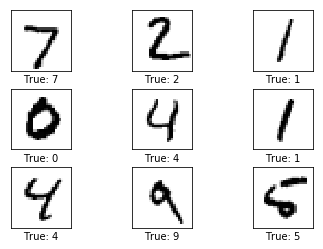

In [5]:
# Testcase for plot_images function
# Get the first 9 images from the test-set
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above
plot_images(images=images, cls_true=cls_true)

## TensorFlow graph

Why using TensorFlow:

- TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph, while NumPy only knows the computation of a single mathematical operation at a time.

- TensorFlow can also automatically calculate the gradients needed to optimize the variables of the graph so as to make the model perform better (The gradient of entire graph can be calculated using chain-rule for derivatives)

- TensorFlow takes advantages of multi-core CPUs as well as GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

- **Placeholder variables** used to feed input into the graph.
- **Model variables** that are going to be optimized so far as to make the model perform better.
- **Model** which is essentially just a mathematical function that calculates some output given the input in the **placeholder variables** and the **model variables**.
- **Cost measure** that can be used to guide the optimization variables.
- **An optimization method** which updates the variables of the model.



In [6]:
# Placeholder variables
# Input image: size=img_size_flat
x = tf.placeholder(tf.float32, [None, img_size_flat])
# Label: size=num_classes (one-hot encoder)
y_true = tf.placeholder(tf.float32, [None, num_classes])
# True class of each image
y_true_cls = tf.placeholder(tf.int64, [None])

In [7]:
# Variables to be optimized
# Weights: initialized with zeros and shape is (img_size_flat x num_classes)
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
# Biases: 1-Dimensional tensor of length (num_classes)
biases = tf.Variable(tf.zeros([num_classes]))

In [8]:
# Model: Y = XW + B
logits = tf.matmul(x, weights) + biases

In [9]:
# Softmax: activation function
y_pred = tf.nn.softmax(logits)
# Archive index of max value of y_pred
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-function to be optimized

To make the model better at classifying the input images, we must know somehow change the variable for `weights` and `biases`. To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` and the desired output `y_true`.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals to zero. The goal of optimization is to minimize the cross-entropy so it gets as close to zero as possible by changine the `weights` and `biases` of the model.

In [10]:
# Cost function: softmax_cross_entropy_with_logits_v2
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)
# Take the average of the cross-entropy for all image classifications
cost = tf.reduce_mean(cross_entropy)

In [32]:
# Optimization method: GradientDescentOptimizer 
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

# Optimization method: AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

### Performance measures

We need a few more performance measures to display the progress to the user. This is a vector of booleans whether the predicted class equals the true class of each image.

In [12]:
# Compare y_pred_cls - y_true_cls and return boolean
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# Calculate the classification accuracy by type-casting the booleans to floats: False-0 and True-1 
# and then calculating the average of these numbers.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

In [35]:
# Create TensorFlow session
session = tf.Session()
session.run(tf.global_variables_initializer())

## Helper function to perform the optimization iterations

There are 55000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. Therefore, we use Stochastic Gradient Descent (SGD) which only uses a small batch of images in each iteration of the optimizer.

In [14]:
batch_size = 100

Function for performing a number of optimization iterations so as to gradually improve the `weights` and `biases` of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [15]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch holds a batch of images,
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        
        # Put the batch into a dict for placeholder variables in TensorFlow graph
        # Note that the placeholder for y_true_cls is not set because it is not
        # used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train to the placeholder
        # variables and then run the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

## Helper functions to show performance

In [16]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

In [17]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [18]:
def print_confusion_matrix():
    # Get the true classification for the test-set.
    cls_true = data.y_test_cls
    
    # Get the predicted classification for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    
    # Plor the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    

In [19]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    
    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been incorrectly classified
    images = data.x_test[incorrect]
    
    # Get predicted classed for those images.
    cls_pred = cls_pred[incorrect]
    
    # Get the true classed for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [20]:
def plot_weights():
    # Get the values for the weights from TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across the images so they
    # can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    
    # Create figure with 3x4 sub-plots, where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3,4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it
            # Note that w.shape == (img_size_flat, 10)
            image = w[:,i].reshape(img_shape)
            
            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {}".format(i))
            
            # Plot the image
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        
        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()
            

## Performance

### After 1 optimization iteration

Accuracy on test-set: 37.3%
Example errors:


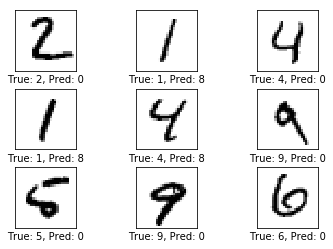

Weights


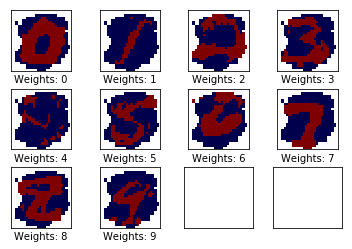

In [36]:
optimize(num_iterations=1)
print_accuracy()
print("Example errors:")
plot_example_errors()
print("Weights")
plot_weights()

### After 10 optimization iterations

Accuracy on test-set: 79.8%
Example errors:


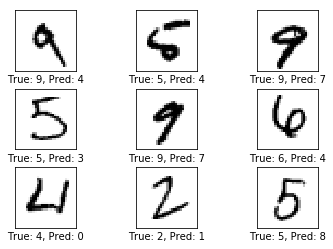

Weights


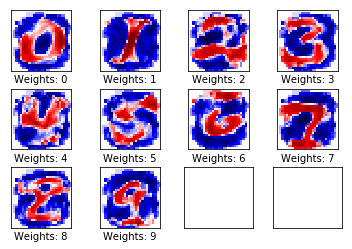

In [37]:
optimize(num_iterations=9)
print_accuracy()
print("Example errors:")
plot_example_errors()
print("Weights")
plot_weights()

### After 1000 optimization iterations

Accuracy on test-set: 91.7%
Example errors:


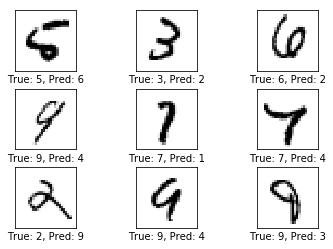

Weights


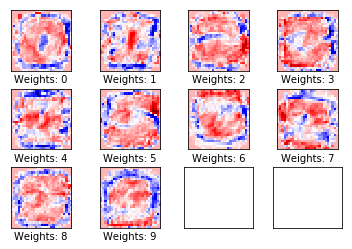

In [38]:
optimize(num_iterations=990)
print_accuracy()
print("Example errors:")
plot_example_errors()
print("Weights")
plot_weights()

[[ 968    0    2    1    0    4    3    1    1    0]
 [   0 1114    5    2    0    1    4    2    7    0]
 [  12   11  955    6    8    1   12    7   16    4]
 [   8    0   35  899    1   31    2    9   16    9]
 [   3    2   12    0  891    0   12    4    6   52]
 [  15    4    5   29    9  783   12    2   25    8]
 [  15    3   10    0    7   17  904    1    1    0]
 [   5    9   30    7    8    0    0  917    3   49]
 [  11   12   22   24    9   31   11    8  825   21]
 [  13    7    2   11   22    9    0   12    6  927]]


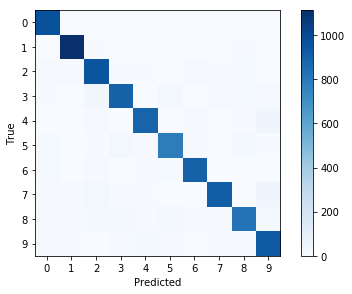

In [24]:
print_confusion_matrix()

In [33]:
session.close()

## Conclusion
 
After 1000 iterations, accuracy:
- 87% with GradientDescentOptimizer
- 91.7% with AdamOptimizer